# Solving Single Decisions

## The "Party Problem" example

JMA 11 Jan 2024

In [50]:
# Imports from the python standard library
import math, re, os, sys
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd

import networkx as nx

# for extract_net
# from ID_operations import * 
from potential_operations import *
import BN

# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource, VBar, Span
# from bokeh.io import output_notebook
# output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

In [51]:
# BN structure is contained under the node branch
parsed = BN.extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

## Bayes networks object

### Include state and variable names to tensor dimensions

### Add graph structure

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Node Potential objects for computation. 


In [52]:
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
pp_net = BN.reap(parsed)
pp_net.pr_nodes()


Edges:  [('Weather', 'Preferences'), ('Party_location', 'Preferences'), ('Weather', 'Detector'), ('Adjustor', 'Detector')] 

>>> Party_location <<<
Party_location: decision
	states: ['Outdoors', 'Porch', 'Indoors']
	parents: []
	named tensor: [('Party_location', 'm')], [3]
       [0.3333, 0.3333, 0.3333]

>>> Weather <<<
Weather: cpt
	states: ['Sunshine', 'Rain']
	parents: []
	named tensor: [('Weather', 'm')], [2]
       [0.4000, 0.6000]

>>> Preferences <<<
Preferences: utility
	states: ['utility']
	parents: ['Weather', 'Party_location']
	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]

>>> Adjustor <<<
Adjustor: cpt
	states: ['absent', 'present']
	parents: []
	named tensor: [('Adjustor', 'm')], [2]
       [0.1000, 0.9000]

>>> Detector <<<
Detector: cpt
	states: ['SaySun', 'SayRain']
	parents: ['Weather', 'Adjustor']
	named tensor: [('Wea

reap: Party_location, decision
reap: Weather, cpt
reap: Preferences, utility
reap: Utility, maux
Unsupported node type: maux
reap: Adjustor, cpt
reap: Detector, cpt


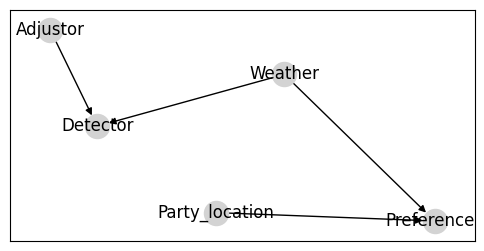

In [53]:
# BN Graph
pp_net.pr_network()

In [54]:
pp_net.pr_influences()



Node	{ancestors}
	{descendants}

Weather :  set() 
	 {'Detector', 'Preferences'} 

Preferences :  {'Weather', 'Party_location'} 
	 set() 

Party_location :  set() 
	 {'Preferences'} 

Detector :  {'Weather', 'Adjustor'} 
	 set() 

Adjustor :  set() 
	 {'Detector'} 



### Extract matrices as tensors.  _List all tensors_

In [55]:
pp_net.pr_named_tensors()

Party_location 
	 OrderedDict({'Party_location': 'm'})
	tensor([0.3333, 0.3333, 0.3333]) 

Weather 
	 OrderedDict({'Weather': 'm'})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Weather': 'c', 'Party_location': 'c', 'Preferences': 'm'})
	tensor([[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 'm'})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Weather': 'c', 'Adjustor': 'c', 'Detector': 'm'})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



In [56]:
## pretty print one of the variables
pp_net.pr_one_dim_table( 'Weather', tablefmt= '.4f', headers= ['State', 'Value'])



 *** Weather ***
State       Value
--------  -------
Sunshine      0.4
Rain          0.6


### Apply risk-preferring utility function

Convert "dollar" utilities to utility with risk tolerance == 0.5

In [57]:
# Utility matrix, as a Potential
outcome_potential = pp_net.get_potential('Preferences')
outcome_potential.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]


In [58]:
# Convert value to utilities
utility_p = named_tensor_apply(outcome_potential, delta_utility, exponand = 0.5, normalize = 50)
utility_p.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[1.0000],
         [0.9504],
         [0.5675]],

        [[0.0000],
         [0.3229],
         [0.6667]]]


In [59]:
# Check that the inverse utility function returns the outcome values
named_tensor_apply(utility_p, delta_inverse_utility, exponand = 0.5, normalize = 50).pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[ -0.],
         [ 20.],
         [ 50.]]]


## Solving the party problem

_Remove Nodes in proper order, using equivalence transformations_

To determine the optimal policy --

* join Adjustor and Detector CPTs, marginalize out Adjustor
* join Detector and Weather CPTs, marginalize out Detector 
* join Weather with Utility (Decision has uniform values for all options before optimization)
* marginalize out unobserved Weather 
* Maximize over decision options to get best policy, and policy expected value. 

In [60]:
# A place to store results
expected_values = pd.DataFrame(np.zeros((2,2)), index = ['EV', 'risk-averse'], columns = ['no_info', 'full_info'])
# expected_values

### First solution - only prior probabilities, no observation 

__1. The Adjustor can be absorbed into the Detector__

In [61]:
# Remove Adjustor
detector_p = pp_net.get_potential('Detector')
adjustor_p = pp_net.get_potential('Adjustor')
detector_marginal = absorb_parent(adjustor_p, detector_p)
print('P(Detector | Weather): ')
detector_marginal.pr_potential()

P(Detector | Weather): 
	named tensor: [('Weather', 'c'), ('Detector', 'm')], [2, 2]
       [[0.8340, 0.1660],
        [0.4080, 0.5920]]


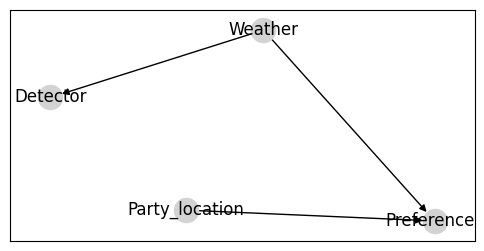

In [62]:
# Now that the Adjustor potential is removed, 
# next we can redraw the network graph
pp_net.remove_node('Adjustor', show_graph=True)

__2. The Detector is a barren node; remove it.__

This has the same effect as reversing the arc and expecting out "Detector."

Note: This just returns the Weather prior, as it should.

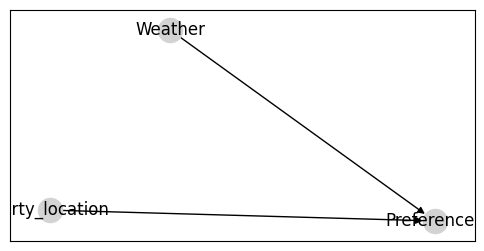

In [63]:
# Delete the Detector node from the network.  No change to Weather potential is needed
pp_net.remove_node('Detector', show_graph=True)

In [64]:
# Check that the Weather prior distribution is unchanged, since
# None of the variables predicted by Weather are observed
weather_marginal = pp_net.get_potential('Weather') 
weather_marginal 

OrderedDict({'Weather': 'm'})
	tensor([0.4000, 0.6000])

__3. Compute the expected outcome value__

The expected value __before__ applying the utility function

Note that the optimal choice is implicit in the EV potential. The party location table is not used here. 

In [65]:
# Before optimization the decision node is set to just a uniform distribution
location_choice = pp_net.get_potential("Party_location")
location_choice

OrderedDict({'Party_location': 'm'})
	tensor([0.3333, 0.3333, 0.3333])

In [66]:
# Recall what the outcome values are, as a function of Weather and Party_location
outcome_potential.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]


_Find best policy before knowing the weather outcome_

First take expectation over the weather outcomes, then choose the best option.
These are the values, depending on location:

In [67]:
alternatives = pp_net.get_node('Party_location').get_states()
expected_outcome = marginalize_utility(outcome_potential, weather_marginal)
# The expected value of each alternative
print('Alternatives:', alternatives)
expected_outcome.pr_potential()

Alternatives: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'c')], [3]
       [40., 48., 46.]


__4. Choose the best location, the one with the highest expected value.__

In [68]:
max_value, which_choice = maximize_utility(expected_outcome, location_choice)
expected_values.loc['EV', 'no_info'] = max_value.cpt.item() 
str(np.array(alternatives)[which_choice.policy == 1]), max_value.cpt.item()

('[]', 48.0)

### Recompute the policy assuming a risk averse utility function

__1. Compute expected risk-adjusted utility__

In [69]:
# Recall the utility-transformed values. 
utility_p.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[1.0000],
         [0.9504],
         [0.5675]],

        [[0.0000],
         [0.3229],
         [0.6667]]]


In [70]:
# Utility expected value over decision alternatives
expected_utility = marginalize_utility(utility_p, weather_marginal)
print('Alternatives:',pp_net.get_node('Party_location').get_states())
expected_utility.pr_potential()

Alternatives: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'c')], [3]
       [0.4000, 0.5739, 0.6270]


In [71]:
v, which_choice = maximize_utility(expected_utility, pp_net.get_potential("Party_location"))
certain_equivalent = delta_inverse_utility(v.cpt.item(), exponand = 0.5, normalize = 50)
expected_values.loc['risk-averse', 'no_info'] = certain_equivalent 
str(np.array(alternatives)[which_choice.policy == 1]),\
f'{v.cpt.item():.3f} = $ {certain_equivalent:.2f}'

('[]', '0.627 = $ 45.83')

### Party problem when Weather is observed before having to choose the location

To solve this --

* Add an informational "cause" to the decision node by
* Using the Weather marginal as a conditioning for Party location

Then repeat the steps above. 

_Alternately add the conditioning arc in the xdsl file instead of programmatically modifying it._

In [72]:
# Adding the weather as a conditioning dimension to the decision
conditioned_choice = condition_decision(location_choice, weather_marginal)
conditioned_choice.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'm')], [2, 3]
       [[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]]


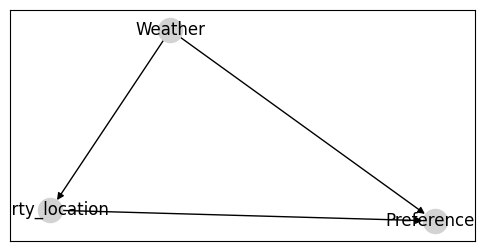

In [73]:
pp_net.network.add_edge("Weather", "Party_location")
pp_net.pr_network()

__Maximize value knowing Weather__

In [74]:

max_cond_value, which_choice = maximize_utility(outcome_potential, conditioned_choice)
print('Best choice depending on knowing the weather:')
# which_choice.policy contains the policy table
BN.pr_table(max_cond_value, 'Weather', pp_net.get_node('Weather').get_states())
# print(f'\nHence the value of knowing the weather is {max_cond_value.cpt[0].item()} - {max_value.cpt.item()}'
# f' = {max_cond_value.cpt[0].item() - max_value.cpt.item()}')

Best choice depending on knowing the weather:
 *** Weather ***
--------  ---
Sunshine  100
Rain       50
--------  ---


__The optimal decision policy__

In [75]:
# Choice as a function of the weather
# Borrow the dimensions from the decision potential
decision_dims = conditioned_choice.get_named_dims()
Potential( which_choice.policy, decision_dims)

OrderedDict({'Weather': 'c', 'Party_location': 'm'})
	OrderedDict({'Weather': 'c', 'Party_location': 'm'})
	tensor([[1., 0., 0.],
        [0., 0., 1.]])

__Compute an expectation viewed from before Weather is known, over the choices made after Weather is known.__

In [76]:
# join(max_cond_value, weather_marginal)
pre_posterior_value = marginalize_utility(max_cond_value, weather_marginal)
expected_values.loc['EV', 'full_info'] = pre_posterior_value.cpt.item()
'pre_posterior_value: ', pre_posterior_value.cpt.item()

('pre_posterior_value: ', 70.0)

__Repeat the analysis for risk averse choice__

We can make a shortcut, and not resolve for the full information expected values, since both are certain values.  Instead we just apply the utility function to them.


In [77]:
full_info_utility = named_tensor_apply(max_cond_value, delta_utility, exponand = 0.5, normalize = 50)
pre_posterior_utility = marginalize_utility(full_info_utility, weather_marginal)
full_info_expected_utility = named_tensor_apply(pre_posterior_utility, delta_inverse_utility, exponand = 0.5, normalize = 50)
expected_values.loc['risk-averse', 'full_info'] = full_info_expected_utility.cpt.item() 
'full_info_expected_utility: ',full_info_expected_utility.cpt.item()

('full_info_expected_utility: ', 66.0964126586914)

### Compare the four solutions, varying information and risk attitude

In [78]:
expected_values

,no_info,full_info
EV,48.00000,70.000000
risk-averse,45.83223,66.096413


In [87]:
df0 = pd.melt(expected_values, value_vars = ['no_info', 'full_info'], value_name= 'VOI')
df0['risk'] =['EV', 'risk_averse', 'EV', 'risk_averse']
df0

,variable,VOI,risk
0,no_info,48.000000,EV
1,no_info,45.832230,risk_averse
2,full_info,70.000000,EV
3,full_info,66.096413,risk_averse


<Figure size 800x600 with 0 Axes>

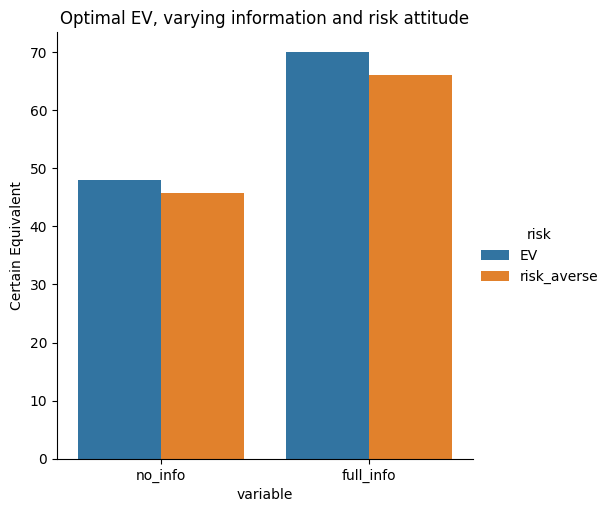

In [92]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.catplot(data=df0, x= 'variable', y = 'VOI', kind='bar', hue='risk')
# sns.barplot(x='Category', y='Value', data=expected_values)
plt.title('Optimal EV, varying information and risk attitude')
# plt.xlabel('Category')
plt.ylabel('Certain Equivalent')
plt.show()

